# 📘 Convergent Learning: Do different neural networks learn the same representations?

This notebook reproduces results from:  
Li et al., ICLR 2016  
[arXiv:1511.07543](http://arxiv.org/1511.07543)

# Import libs and functions
Imports required libraries and modules such as PyTorch, NumPy, and plotting tools to support model training, data processing, and visualization.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Subset
import os
import random
import numpy as np
from tqdm import tqdm
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Helper Functions / Config Functions
Defines reusable utility functions, including those for plotting mean activations and correlation heatmaps between networks.

In [2]:
def read_val_single_moc(net_path, layer):
    '''
    Reads means, outers, cor for a single net.
    Assumes files are saved with .pt extension using torch.save().
    `net_path` should be something like 'net0/' or '../data/net0/'.
    '''
    # Load mean
    mean_path = os.path.join(net_path, 'val_mean', f'{layer}.pt')
    # Use torch.load() to load .pt files
    means = torch.load(mean_path)
    print(f"Loaded mean from: {mean_path}")

    # Load outer product
    outer_path = os.path.join(net_path, 'val_outer', f'{layer}.pt')
    # Use torch.load() to load .pt files
    outer = torch.load(outer_path)
    print(f"Loaded outer from: {outer_path}")

    # Load correlation matrix
    cor_path = os.path.join(net_path, 'val_cor', f'{layer}.pt')
    # Use torch.load() to load .pt files
    cor = torch.load(cor_path)
    print(f"Loaded correlation from: {cor_path}")

    return means, outer, cor

In [3]:
def read_val_double_cors(base_xcors_path, layer, combo):
    '''
    Reads cross-correlation matrix for a pair of nets.
    `base_xcors_path` should be the directory where cross-correlation files are stored,
    e.g., 'data/net0' if all cross-correlations are symlinked there.
    `layer` is the layer name (e.g., 'conv1').
    `combo` is the combination string (e.g., '01' for net0 and net1).
    '''

    xcors_path = os.path.join(base_xcors_path, 'val_xcors', f'{layer}_{combo}.pt')
    xcors_path = os.path.join(base_xcors_path, 'val_xcors', f'{layer}_{combo}.pt')

    xcors = torch.load(xcors_path)
    print(f"Loaded xcors from: {xcors_path}")
    return xcors


In [4]:
def register_conv_hooks(model, activations, layer_names):
    def get_activation(name):
        def hook(_, __, output):
            activations[name] = output.detach()
        return hook

    conv_count = 0
    for idx, layer in enumerate(model.module.convs):  # assuming DataParallel
        if isinstance(layer, torch.nn.Conv2d):
            if conv_count < len(layer_names):
                layer_name = layer_names[conv_count]
                layer.register_forward_hook(get_activation(layer_name))
                print(f"✓ Hook registered on {layer_name} at convs[{idx}]")
                conv_count += 1


In [5]:
def figsize(width, height):
    """Sets the figure size for matplotlib plots."""
    rcParams['figure.figsize'] = (width, height)

def get_float_copy(arr):
    '''
    Returns a copy of an array, upconverting int types to float.
    Handles both numpy.ndarray and torch.Tensor inputs.
    '''
    if isinstance(arr, torch.Tensor):
        # Convert PyTorch Tensor to NumPy array on CPU, then copy
        arr_np = arr.detach().cpu().numpy()
        if 'int' in str(arr_np.dtype):
            return arr_np.astype(float)
        else:
            return arr_np.copy()
    elif isinstance(arr, np.ndarray):
        # Handle NumPy array
        if 'int' in str(arr.dtype):
            return arr.astype(float)
        else:
            return arr.copy()
    else:
        # For other types, try a generic copy or raise an error
        raise TypeError(f"Unsupported data type for get_float_copy: {type(arr)}")

def norm01(arr):
    """Normalizes array values to the range [0, 1]."""
    arr = get_float_copy(arr)
    # Handle cases where min and max might be the same (e.g., constant array)
    arr_min = arr.min()
    arr_max = arr.max()
    if arr_max == arr_min:
        return np.zeros_like(arr) # Return zeros if all values are the same
    arr -= arr_min
    arr /= (arr_max - arr_min)
    return arr

def norm01c(arr, center):
    '''Maps the center value to .5 and normalizes to [0, 1].'''
    arr = get_float_copy(arr)
    arr -= center
    # Avoid division by zero if range is too small
    max_abs_val = max(2 * arr.max(), -2 * arr.min())
    if max_abs_val == 0:
        return np.full_like(arr, 0.5) # Return 0.5 if all values are the same as center
    arr /= max_abs_val
    arr += .5
    # Assertions for debugging, can be removed in production
    assert arr.min() >= -1e-6 # Allow tiny floating point errors
    assert arr.max() <= 1 + 1e-6 # Allow tiny floating point errors
    return arr

def showimage(im, c01=False, bgr=False, axes=None):
    """
    Displays an image.
    Args:
        im (numpy.ndarray): The image data.
        c01 (bool): If True, transpose from (C, H, W) to (H, W, C).
        bgr (bool): If True, convert BGR to RGB.
        axes (matplotlib.axes.Axes): Axes to plot on.
    """
    # Ensure im is a numpy array before processing
    if isinstance(im, torch.Tensor):
        im = im.detach().cpu().numpy()

    if c01 and im.ndim == 3:
        # switch order from c,0,1 -> 0,1,c
        im = im.transpose((1,2,0))
    if im.ndim == 3 and bgr:
        # Change from BGR -> RGB
        im = im[:, :, ::-1]

    if axes is None:
        plt.imshow(im)
    else:
        axes.imshow(im)

def showimagesc(im, c01=False, bgr=False, center=None, axes=None):
    """
    Displays an image with a color scale, normalizing its values.
    Args:
        im (numpy.ndarray or torch.Tensor): The image data.
        c01 (bool): If True, transpose from (C, H, W) to (H, W, C).
        bgr (bool): If True, convert BGR to RGB.
        center (float, optional): Value to map to 0.5 for normalization.
        axes (matplotlib.axes.Axes): Axes to plot on.
    """
    # Ensure im is a numpy array before passing to norm functions
    if isinstance(im, torch.Tensor):
        im = im.detach().cpu().numpy()

    if center is None:
        showimage(norm01(im), c01=c01, bgr=bgr, axes=axes)
    else:
        showimage(norm01c(im, center), c01=c01, bgr=bgr, axes=axes)

# Data Loading / Preprocessing
Loads the ImageNet dataset.

In [6]:
# Contants
GPUS = [0]
EPOCHS = 2
NO_CLASSES = 1000
TRAIN_DIR = 'tiny-imagenet-200/train'
VAL_DIR = 'tiny-imagenet-200/val'
IMG_DIM = 227
BATCH_SIZE = 128
L_RATE = 0.01
W_DECAY = 0.0005
MOMENTUM = 0.9
CHECKPOINT_DIR = 'checkpoints/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = torch.initial_seed()

In [7]:
# image augmentation and tranformation
data_transform = transforms.Compose([
    transforms.CenterCrop(IMG_DIM),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5,0.5], std=[0.5,0.5,0.5])
])

# parepare the dataset
train_dataset = datasets.ImageFolder(TRAIN_DIR, data_transform)
val_dataset = datasets.ImageFolder(VAL_DIR)

# Take only the first 1000 samples from each dataset
train_subset = Subset(train_dataset, range(1000))
val_subset = Subset(val_dataset, range(1000))

train_loader = DataLoader(
    train_subset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    # num_workers=8
)
val_loader = DataLoader(
    val_subset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    # num_workers=8
)



# Model Definition / Training
Defines the architecture of the networks and carries out the training procedure for each model.

In [8]:
# contains total 8 layers with 5 convs and 3 dense
# input images size = 256 x 256
# softmax activation function after last layer 
# Response Normalization layers apply after only to 1st and 2nd Convs layer
# follow MaxPolling layer after Response Normalization layers and also after the 5th Conv layer
# apply ReLU after every MaxPooling layer and fully connected layer

# -- CNN layers --
# 1st layer -> input_dim = 224 x 224 x 3, output_dim = 11 x 11 x 3, kernels = 96, stride = 4
# 2nd layer -> input_dim = 11 x 11 x 3, output_dim = 5 x 5 x 48, kernels = 256, stride = 1
# 3rd layer -> input_dim = 5 x 5 x 48, output_dim = 3 x 3 x 256, kernels = 348, stride = 1
# 4th layer -> input_dim = 3 x 3 x 256, output_dim = 3 x 3 x 192, kenel_size = 348, stride = 1
# 5th layer -> input_dim = 3 x 3 x 192, output_dim = 3 x 3 x 192, kernels = 256, stride = 1

class AlexNet(nn.Module):
    def __init__(self, no_of_classes):
        super(AlexNet, self).__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=1),  # N x 96 x 55 x 55,
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2), # N x 96 x 27 x 27,
            nn.ReLU(),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5),  # N x 256 x 23 x 23
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),  # N x 256 x 11 x 11
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=348, kernel_size=3),  # N x 348 x 9 x 9
            nn.ReLU(),
            nn.Conv2d(in_channels=348, out_channels=348, kernel_size=3), # N x 348 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(in_channels=348, out_channels=256, kernel_size=3),  # N x 348 x 5 x 5
            nn.MaxPool2d(kernel_size=3, stride=2), # N x 256 x 2 x 2
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(), # N x 1024
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 2 * 2), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.Softmax()
        )
        self.init_parameter()
        
    def init_parameter(self):
        for layer in self.convs:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.1),
                nn.init.constant_(layer.bias, 0)
            
        nn.init.constant_(self.convs[4].bias, 1)
        nn.init.constant_(self.convs[10].bias, 1)
        nn.init.constant_(self.convs[12].bias, 1)
        nn.init.constant_(self.classifier[2].bias, 1)
        nn.init.constant_(self.classifier[5].bias, 1)
        nn.init.constant_(self.classifier[7].bias, 1)
        
    
    def forward(self, x):
        x = self.convs(x)
        x = self.classifier(x)
        return x
        

In [9]:
# create model
model = AlexNet(NO_CLASSES).to(device)

# train with multi GPU
model = torch.nn.parallel.DataParallel(model, device_ids=GPUS)
print(model)


DataParallel(
  (module): AlexNet(
    (convs): Sequential(
      (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
      (1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
      (5): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
      (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): ReLU()
      (8): Conv2d(256, 348, kernel_size=(3, 3), stride=(1, 1))
      (9): ReLU()
      (10): Conv2d(348, 348, kernel_size=(3, 3), stride=(1, 1))
      (11): ReLU()
      (12): Conv2d(348, 256, kernel_size=(3, 3), stride=(1, 1))
      (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): ReLU()
    )
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Dropout(p=0.5, inplace=False)
      (2)

In [10]:
# optimizer
optim = torch.optim.SGD(
    model.parameters(),
    lr=L_RATE,
    momentum=MOMENTUM,
    weight_decay=W_DECAY
)
# loss function
criterion = nn.CrossEntropyLoss()

# decay the learning rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=50, gamma=0.1)

total_steps =1


In [11]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [12]:
# Map friendly names to actual layer indices inside model.features
layer_map = {
    'conv1': 0,
    'conv2': 4,
    'conv3': 8,
    'conv4': 10,
    'conv5': 12,
}
layer_names = ['conv1', 'conv2', 'conv3', 'conv4','conv5']

In [13]:

all_model_avg_activations = {n: [] for n in layer_names}
num_models_to_process = 2 # As per your range(2)

# ---- Main loop for multiple models (collecting individual stats) ----
for model_id in range(num_models_to_process):
    set_seed(model_id)

    model = AlexNet(NO_CLASSES).to(device)
    model = torch.nn.DataParallel(model, device_ids=GPUS)
    model.eval()

    activations = {}
    mean_activations_per_batch = {n: [] for n in layer_names} # Renamed for clarity
    register_conv_hooks(model, activations, layer_names) # Register hooks

    with torch.no_grad():
        for X, _ in tqdm(train_loader, desc=f'net{model_id} activations'):
            X = X.to(device)
            _ = model(X) # Forward pass to trigger hooks and populate 'activations'

            # Collect means per batch
            for n in layer_names:
                if n in activations: # Check if activation was captured for this layer
                    act = activations[n]
                    if act.ndim == 4: # Conv layer output [B, C, H, W]
                        mean_activations_per_batch[n].append(act.mean(dim=(0, 2, 3)).cpu()) # → [C]
                    elif act.ndim == 2: # FC layer output [B, C]
                        mean_activations_per_batch[n].append(act.mean(dim=0).cpu()) # → [C]
                else:
                    # This warning indicates a hook might not have fired or layer name mismatch
                    print(f"Warning: No activation found for layer {n} during batch processing for net{model_id}. Check hook registration.")

    # --- Save the computed statistics for the current model_id (AFTER all batches) ---
    base_folder = f'net{model_id}/' # e.g., 'net0/', 'net1/'
    os.makedirs(base_folder, exist_ok=True)

    # Create subfolders for mean, outer, cor
    mean_folder = os.path.join(base_folder, 'val_mean')
    outer_folder = os.path.join(base_folder, 'val_outer')
    cor_folder = os.path.join(base_folder, 'val_cor')

    os.makedirs(mean_folder, exist_ok=True)
    os.makedirs(outer_folder, exist_ok=True)
    os.makedirs(cor_folder, exist_ok=True)

    for n in layer_names:
        # DEBUG: Check if mean_activations_per_batch[n] is empty before proceeding
        print(f"--- Debugging mean_activations_per_batch for layer '{n}' (net{model_id}): ---")
        print(f"  Is empty: {not mean_activations_per_batch[n]}")
        print(f"  Length: {len(mean_activations_per_batch[n])}")
        print("-----------------------------------------------------------------")

        if mean_activations_per_batch[n]: # Ensure there's data to stack
            avg = torch.stack(mean_activations_per_batch[n]).mean(0) # shape: [C]
            all_model_avg_activations[n].append(avg) # Store for cross-correlation later

            # Step 1: Compute and save mean (val_mean)
            mean_path = os.path.join(mean_folder, f'{n}.pt')
            torch.save(avg, mean_path)
            print(f'✓ saved {mean_path}')

            # Step 2: Outer product (used for self-correlation)
            outer = torch.outer(avg, avg)
            outer_path = os.path.join(outer_folder, f'{n}.pt')
            torch.save(outer, outer_path)
            print(f'✓ saved {outer_path}')

            # Step 3: Self-correlation matrix (val_cor)
            diag = torch.sqrt(torch.diag(outer) + 1e-12)
            diag[diag == 0] = 1.0
            corr = outer / (diag.unsqueeze(0) * diag.unsqueeze(1))
            corr_path = os.path.join(cor_folder, f'{n}.pt')
            torch.save(corr, corr_path)
            print(f'✓ saved {corr_path}')
        else:
            print(f"Skipping saving for layer {n} as no activations were collected for net{model_id}.")


for layer_name_debug in layer_names:
    print(f"Layer '{layer_name_debug}': {len(all_model_avg_activations[layer_name_debug])} entries collected.")
    if all_model_avg_activations[layer_name_debug]:
        for i, avg_tensor in enumerate(all_model_avg_activations[layer_name_debug]):
            print(f"  Model {i} avg shape: {avg_tensor.shape}")



# net_dirs = [f'net{i}' for i in range(num_models_to_process)]
# net_paths = ['data/' + dd for dd in net_dirs]

base_xcors_dir = 'xcors'

# Create the val_xcors subfolder within the base_xcors_dir
xcors_folder = os.path.join(base_xcors_dir, 'val_xcors')
os.makedirs(xcors_folder, exist_ok=True)

for layer_name in layer_names:
    collected_count = len(all_model_avg_activations[layer_name])
    condition_result = collected_count < num_models_to_process

    if condition_result: # This is the condition that prints the warning
        print(f"Warning: Not enough models processed to calculate cross-correlations for layer {layer_name}.")
        continue

    for n0_idx in range(num_models_to_process):
        for n1_idx in range(n0_idx + 1, num_models_to_process): # Iterate through unique pairs (n0, n1 where n0 < n1)
            avg_n0 = all_model_avg_activations[layer_name][n0_idx]
            avg_n1 = all_model_avg_activations[layer_name][n1_idx]

            # Calculate cross-correlation (outer product of mean activations)
            xcors_matrix = torch.outer(avg_n0, avg_n1)

            # Define filename: e.g., 'conv1_01.pt' for conv1 between net0 and net1
            xcors_filename = f'{layer_name}_{n0_idx}{n1_idx}.pt'
            xcors_path = os.path.join(xcors_folder, xcors_filename)

            torch.save(xcors_matrix, xcors_path)
            print(f'✓ saved cross-correlation {xcors_path}')

✓ Hook registered on conv1 at convs[0]
✓ Hook registered on conv2 at convs[4]
✓ Hook registered on conv3 at convs[8]
✓ Hook registered on conv4 at convs[10]
✓ Hook registered on conv5 at convs[12]


net0 activations:   0%|                                                                             | 0/8 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
net0 activations: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.44s/it]


--- Debugging mean_activations_per_batch for layer 'conv1' (net0): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net0/val_mean\conv1.pt
✓ saved net0/val_outer\conv1.pt
✓ saved net0/val_cor\conv1.pt
--- Debugging mean_activations_per_batch for layer 'conv2' (net0): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net0/val_mean\conv2.pt
✓ saved net0/val_outer\conv2.pt
✓ saved net0/val_cor\conv2.pt
--- Debugging mean_activations_per_batch for layer 'conv3' (net0): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net0/val_mean\conv3.pt
✓ saved net0/val_outer\conv3.pt
✓ saved net0/val_cor\conv3.pt
--- Debugging mean_activations_per_batch for layer 'conv4' (net0): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net0/val_mean\conv4.pt
✓ saved net0/val_outer

net1 activations: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.20s/it]

--- Debugging mean_activations_per_batch for layer 'conv1' (net1): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net1/val_mean\conv1.pt
✓ saved net1/val_outer\conv1.pt
✓ saved net1/val_cor\conv1.pt
--- Debugging mean_activations_per_batch for layer 'conv2' (net1): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net1/val_mean\conv2.pt
✓ saved net1/val_outer\conv2.pt
✓ saved net1/val_cor\conv2.pt
--- Debugging mean_activations_per_batch for layer 'conv3' (net1): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net1/val_mean\conv3.pt
✓ saved net1/val_outer\conv3.pt
✓ saved net1/val_cor\conv3.pt
--- Debugging mean_activations_per_batch for layer 'conv4' (net1): ---
  Is empty: False
  Length: 8
-----------------------------------------------------------------
✓ saved net1/val_mean\conv4.pt
✓ saved net1/val_outer

# Load data for all nets in group
Loads precomputed mean activations, outer products, and correlation matrices for all networks and layers.

In [14]:
netidxs = [0, 1]  # Extend as needed
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
# End with slash
net_dirs = [
    'net0',
    'net1',
    ]
net_paths = [dd for dd in net_dirs]

l_means, l_outers, l_cors = dict(), dict(), dict()
for layer in layer_names:
    means,outers,cors = [], [], []
    for net_path in net_paths:
        moc = read_val_single_moc(net_path, layer)
        means.append(moc[0])
        outers.append(moc[1])
        cors.append(moc[2])
    l_means[layer] = means
    l_outers[layer] = outers
    l_cors[layer] = cors


Loaded mean from: net0\val_mean\conv1.pt
Loaded outer from: net0\val_outer\conv1.pt
Loaded correlation from: net0\val_cor\conv1.pt
Loaded mean from: net1\val_mean\conv1.pt
Loaded outer from: net1\val_outer\conv1.pt
Loaded correlation from: net1\val_cor\conv1.pt
Loaded mean from: net0\val_mean\conv2.pt
Loaded outer from: net0\val_outer\conv2.pt
Loaded correlation from: net0\val_cor\conv2.pt
Loaded mean from: net1\val_mean\conv2.pt
Loaded outer from: net1\val_outer\conv2.pt
Loaded correlation from: net1\val_cor\conv2.pt
Loaded mean from: net0\val_mean\conv3.pt
Loaded outer from: net0\val_outer\conv3.pt
Loaded correlation from: net0\val_cor\conv3.pt
Loaded mean from: net1\val_mean\conv3.pt
Loaded outer from: net1\val_outer\conv3.pt
Loaded correlation from: net1\val_cor\conv3.pt
Loaded mean from: net0\val_mean\conv4.pt
Loaded outer from: net0\val_outer\conv4.pt
Loaded correlation from: net0\val_cor\conv4.pt
Loaded mean from: net1\val_mean\conv4.pt
Loaded outer from: net1\val_outer\conv4.pt

In [15]:
xcors_path = 'xcors'
l_xcors = {}

for layer in layer_names:
    l_xcors[layer] = {}
    for i in netidxs:
        l_xcors[layer][i] = {}
        for j in netidxs:
            if i >= j:
                continue  

            combo = f"{min(i, j)}{max(i, j)}"
            base_xcors_path = xcors_path
            l_xcors[layer][i][j] = read_val_double_cors(base_xcors_path, layer, combo)


Loaded xcors from: xcors\val_xcors\conv1_01.pt
Loaded xcors from: xcors\val_xcors\conv2_01.pt
Loaded xcors from: xcors\val_xcors\conv3_01.pt
Loaded xcors from: xcors\val_xcors\conv4_01.pt
Loaded xcors from: xcors\val_xcors\conv5_01.pt


# Plot unit mean activations
Generates visualizations comparing average activations of neurons across networks.

In [16]:
def plot_means(layer, do_legend=True, light=False, fileout=None):
    plt.figure(figsize=(12, 6))
    
    for ii, idx in enumerate(netidxs):
        rr = ii / (len(netidxs) - 1 + 1e-6)
        clr = (1, .8 * rr, 0)
        dat = -np.sort(-l_means[layer][idx])  # Sort descending

        if light:
            rcParams.update({'font.size': 22})
            plt.plot(dat, '-', color=clr, lw=3)
            plt.plot(0, dat[0], 'o', color=clr, ms=12)
            plt.plot(len(dat), dat[-1], 'o', color=clr, ms=12)
        else:
            rcParams.update({'font.size': 16})
            plt.plot(dat, 'o-', color=clr, lw=2, ms=9)
    
    plt.axis('tight')
    
    # Fix looser — you likely need a custom implementation or remove this
    try:
        ax = looser(plt.axis(), .01, .02)
        plt.axis(ax[0:2] + (min(ax[2], 0),) + ax[3:4])
    except NameError:
        pass  # If 'looser' is undefined, skip adjusting the axis
    
    if do_legend:
        plt.legend(('Net1', 'Net2', 'Net3', 'Net4'))
    if not light:
        plt.xlabel('Channel number (sorted)')
        plt.ylabel('Mean activation')
    plt.title(layer)
    
    if fileout:
        plt.savefig(fileout + '.pdf')
        plt.savefig(fileout + '.png')

    plt.show()


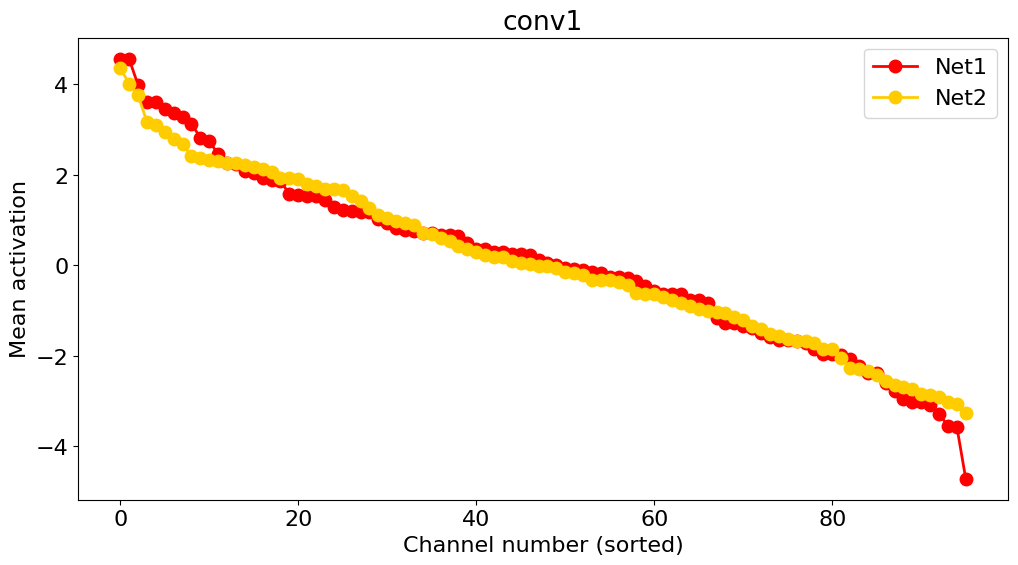

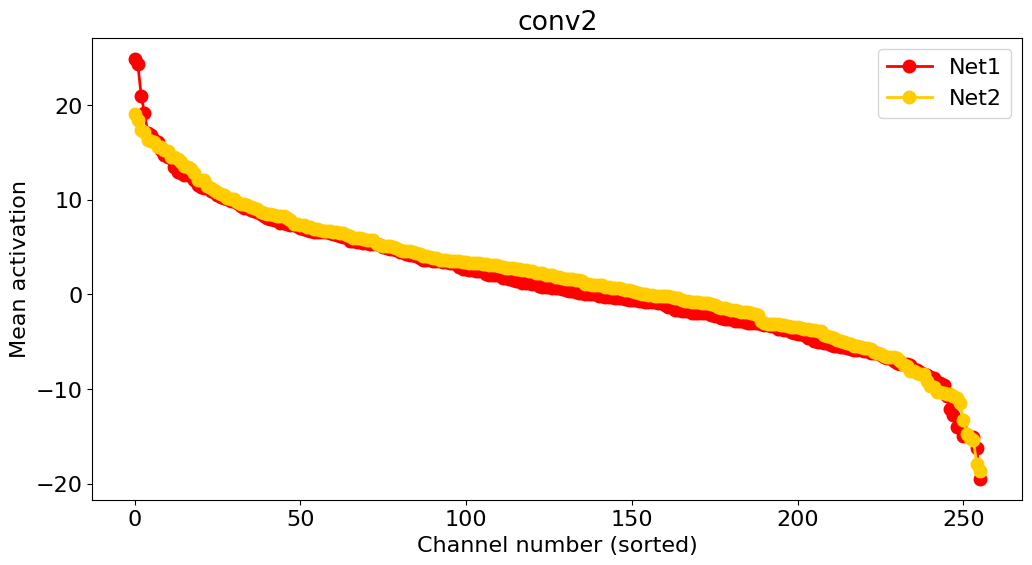

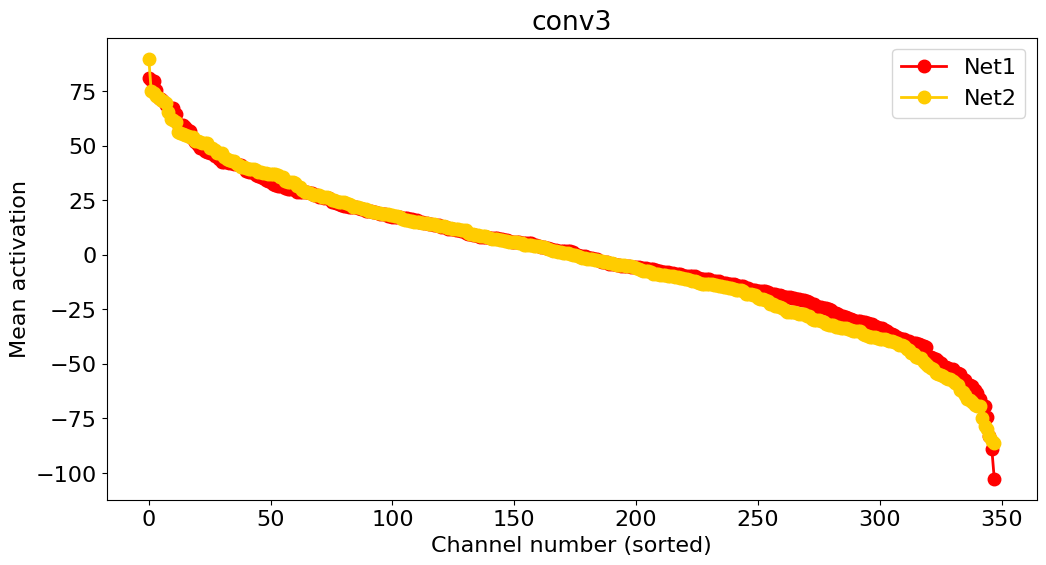

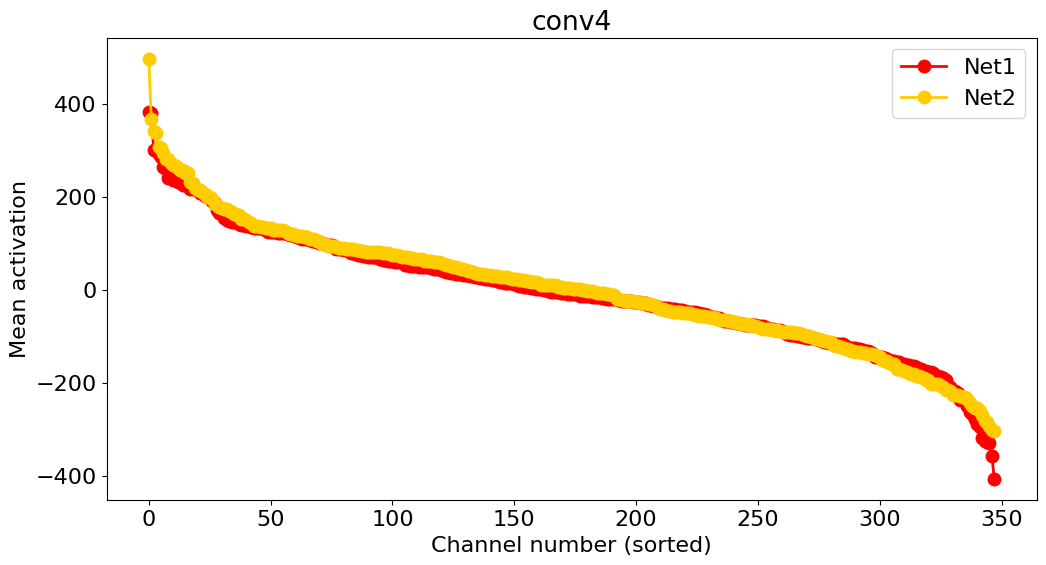

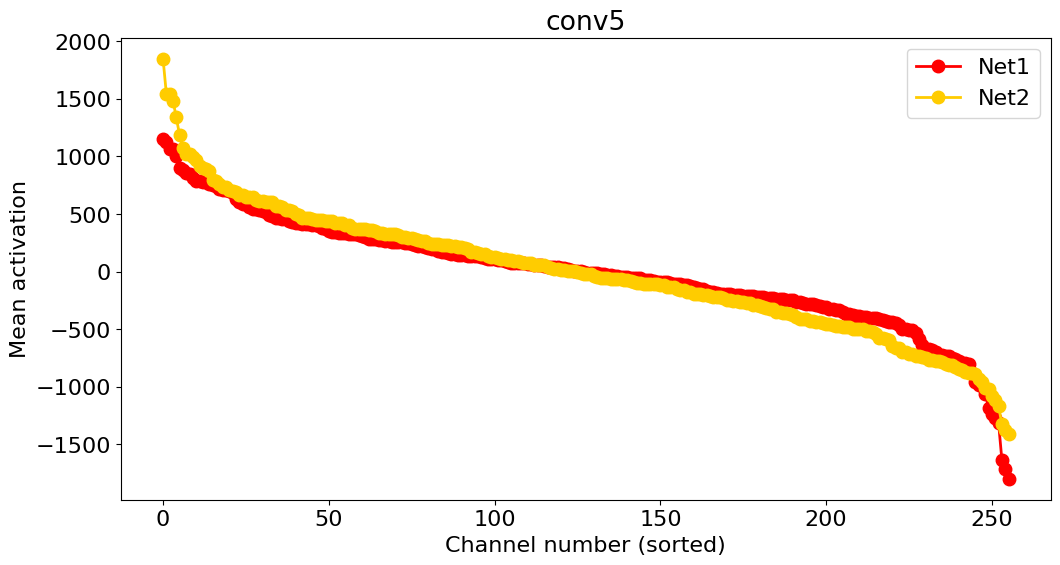

In [17]:
for name in layer_names:
    plot_means(name)

## Plot correlation matrices
Visualizes the correlation matrices to assess how similarly neurons in different networks are activated.

In [18]:
net0 = 0
net1 = 1
layer = 'conv1'
means, outers, cors = l_means[layer], l_outers[layer], l_cors[layer]

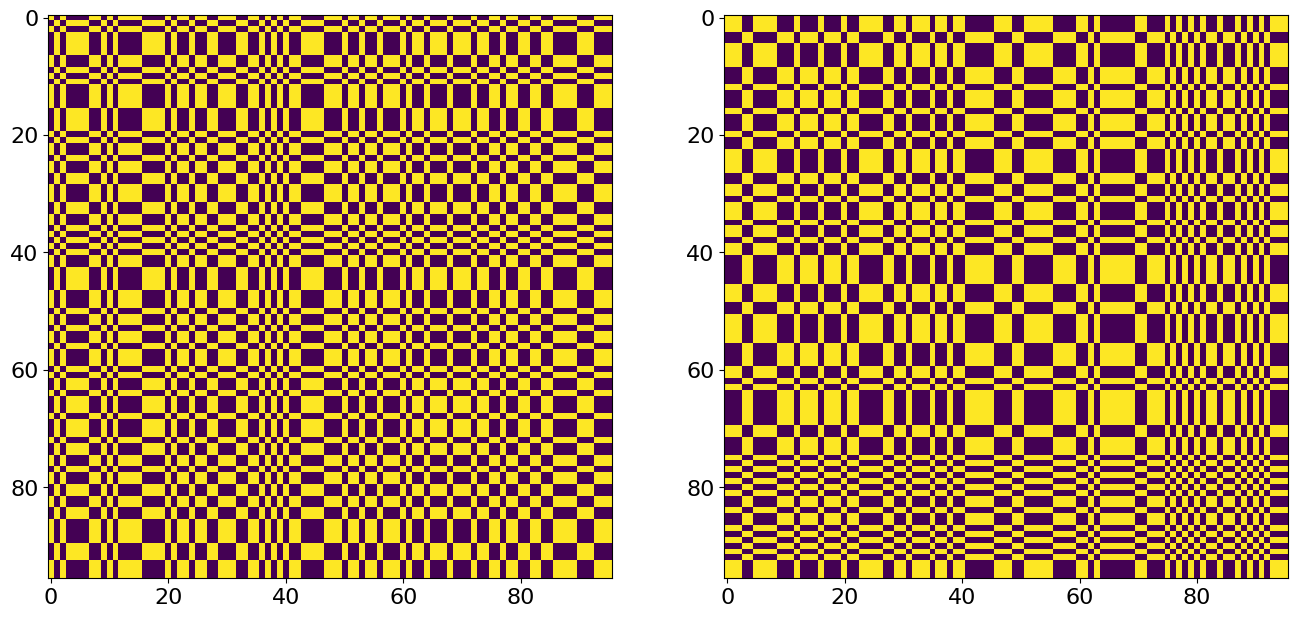

In [19]:
# Plot the within-net correlation matrices of net0 and net1 (conv1 layer). 
# See Fig 1 (a)(b) in http://arxiv.org/pdf/1511.07543v2.pdf
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
showimagesc(cors[net0])
plt.subplot(1,2,2)
showimagesc(cors[net1])

In [20]:
def max_match_order(mat, ignore_diag = False):
    """
    Finds a permutation order using maximum weight matching on a bipartite graph.
    Assumes mat is a numpy array.
    """
    # Ensure mat is a numpy array for networkx
    if isinstance(mat, torch.Tensor):
        mat = mat.detach().cpu().numpy()

    gg = nx.Graph()
    assert mat.shape[0] == mat.shape[1]
    size = mat.shape[0]
    for ii in range(size): # Corrected from xrange to range
        for jj in range(size): # Corrected from xrange to range
            if ignore_diag and ii == jj:
                continue
            gg.add_edge(ii, jj + size, weight=mat[ii, jj])

    matching = nx.max_weight_matching(gg, maxcardinality=True)
    # Convert matching to a list of (node1, node2) tuples and then to a dict for easier lookup
    # NetworkX max_weight_matching returns a set of edges; convert to a dict for order
    order_dict = {}
    for u, v in matching:
        if u < size: # u is from the left side (original index)
            order_dict[u] = v - size
        else: # v is from the left side (original index)
            order_dict[v] = u - size

    # Create the order array based on the matching
    order = np.zeros(size, dtype=int) # Corrected from array to np.array
    for i in range(size):
        if i in order_dict:
            order[i] = order_dict[i]
        else:
            # Handle cases where a node might not be matched if maxcardinality=False
            # Given maxcardinality=True and square matrix, all nodes should be matched.
            # This path should ideally not be taken for a perfect matching.
            pass
    return order

In [21]:
def follow_loops(order):
    '''
    Follows cycles in a permutation order.
    Args:
        order (numpy.ndarray): A 1D numpy array representing the permutation.
                               order[i] is the element that i maps to.
    Returns:
        tuple: A tuple containing:
               - ret (list): The elements in the order they are visited through cycles.
               - lengths (list): The lengths of the cycles found.
    '''
    seen = set()
    ret = []
    lengths = []
    while len(seen) < len(order):
        # Find first unvisited element to start a new cycle
        idx_start = -1
        for ii in range(len(order)):
            if ii not in seen:
                idx_start = ii
                break
        
        if idx_start == -1: # Should not happen if loop condition is correct
            break

        this_length = 1
        ret.append(idx_start)
        seen.add(idx_start)
        
        current_idx = order[idx_start] # Follow the permutation
        while current_idx != idx_start:
            ret.append(current_idx)
            seen.add(current_idx)
            current_idx = order[current_idx]
            this_length += 1
        lengths.append(this_length)
    return ret, lengths

In [22]:
# Find max bipartite matching of between-net correlation matrix
match_no_diag = max_match_order(l_xcors["conv1"][0][1])
loop_order, loop_len = follow_loops(match_no_diag)

In [23]:
def permute_matrix(mat, new_order):
    """Permutes rows and columns of a matrix according to new_order."""
    new_order = np.array(new_order) # Corrected: Use np.array
    ret = mat[new_order, :][:, new_order]
    if isinstance(mat, torch.Tensor):
        mat_np = mat.detach().cpu().numpy()
        ret_np = ret.detach().cpu().numpy()
    else:
        mat_np = mat
        ret_np = ret
    assert np.all(abs(np.sort(mat_np.sum(0)) - np.sort(ret_np.sum(0))) < 1.0), 'sanity check (col sums)'
    assert np.all(abs(np.sort(mat_np.sum(1)) - np.sort(ret_np.sum(1))) < 1.0), 'sanity check (row sums)'
    return ret

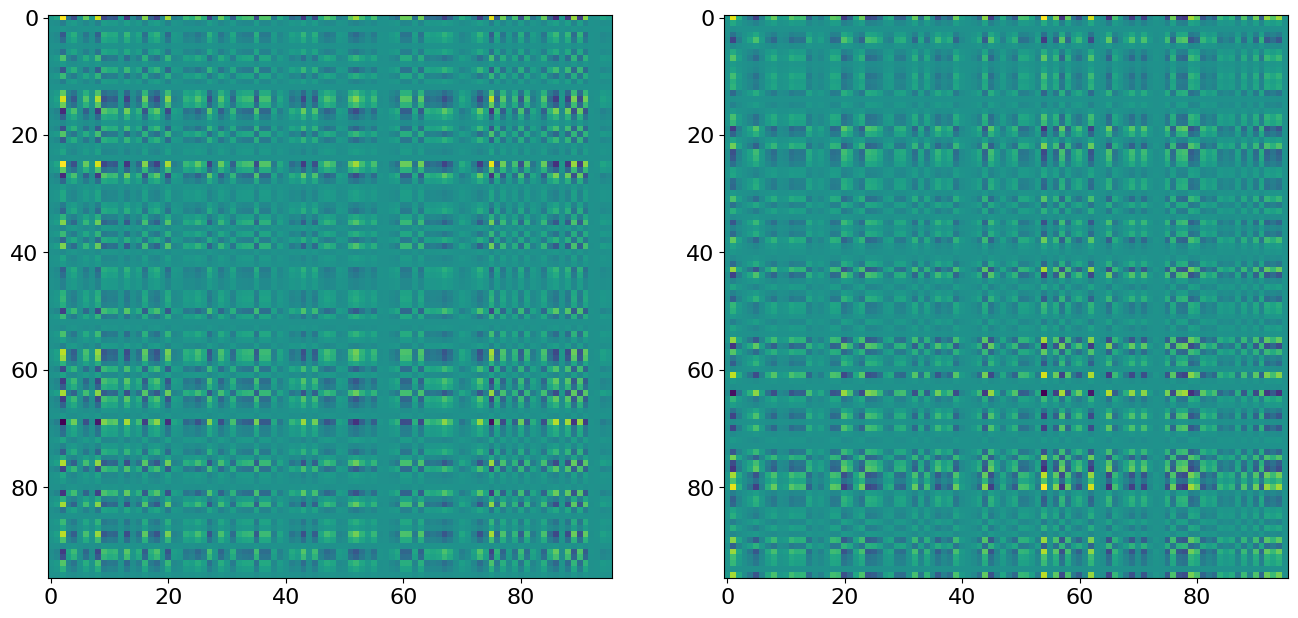

In [24]:
# Between-net correlation for Net1 vs. Net2. 
figsize(16,8)
plt.subplot(1,2,1)
showimagesc(l_xcors["conv1"][0][1])
plt.subplot(1,2,2)
showimagesc(permute_matrix(l_xcors["conv1"][0][1],loop_order))